Activity Extraction
===

Edit: I don't think this notebook ended up being for any of the things described below. We did use it to generate the qualitative data for analysis in the associated [spreadsheet](https://docs.google.com/spreadsheets/d/1i5YQZliK07ocOp0sQ2fBfYrEAj1js6xmjPJ3HKrU_IE/edit?usp=sharing).  My vague recollection is that I was planning to create data files with the appropriate subsets, and ended up deciding against it.

Original comment:

The goal of this notebook is to pull into intermediary data files all of the data that might be used for subsequent analyses.

 - Comment
 - Amp
 - Guestbook
 - Site_profile
 
Note we can extract Reactions on the fly (since the data is small), although we should probably do so anyway.

We also don't need to extract Journal data, since we have the metadata in the dataframe, database, etc.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.family'] = "serif"

In [3]:
import csv
import json
import bson
from bson.codec_options import CodecOptions
from bson.raw_bson import RawBSONDocument
from bson import ObjectId
import gzip

import os
from tqdm import tqdm
import pickle
from glob import glob
from copy import copy, deepcopy

from datetime import datetime
from dateutil.relativedelta import relativedelta
import dateutil
import pytz

from pprint import pprint

In [4]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/1/lana/levon003/repos/recsys-peer-match')

In [5]:
import sys
caringbridge_core_path = "/home/lana/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [6]:
import cbcore.data.paths
import cbcore.data.dates
from cbcore.data.utils import extract_long

In [7]:
assert os.path.exists(cbcore.data.paths.raw_data_filepath)

In [8]:
caringbridge_core_path = "/home/lana/levon003/repos/recsys-peer-match/src"
sys.path.append(caringbridge_core_path)

In [9]:
import cbrec.data

In [10]:
import cbrec.genconfig
import cbrec.text.textdb

### Loading previous batch recommendations

In [11]:
participant_data_dir = os.path.join(cbcore.data.paths.projects_data_dir, 'recsys-peer-match', 'participant')
!ls {participant_data_dir}/*.ndjson

/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/all_author_visits.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b0.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b10.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b1.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b2.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b3.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b4.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b5.ndjson
/home/lana/shared/caringbridge/data/projects/recsys-peer-match/participant/participant_rec_data_b6.ndjson
/home/lana/shared/caringbridge/data/projects/recsys

In [12]:
# load in recommendations from previous rounds
d = []
for batch_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    participant_data_filepath = os.path.join(participant_data_dir, f'participant_rec_data_b{batch_id}.ndjson')
    with open(participant_data_filepath, 'r') as infile:
        for line in infile:
            participant = json.loads(line)
            del participant['site_scores']
            participant['batch_id'] = batch_id
            d.append(participant)

len(d)

838

In [ ]:
batch_df = pd.DataFrame(d)
batch_df.head()

In [ ]:
batch_df.sse_site_list.iloc[0][0]

In [15]:
participant_recced_site_map = {}
for participant_id, group in batch_df.groupby('participant_id'):
    recced_site_ids = []
    for sse_site_list in group.sse_site_list:
        recced_site_ids.extend([site['site_id'] for site in sse_site_list])
    assert len(recced_site_ids) == len(set(recced_site_ids)), "Duplicate rec was given."
    recced_site_ids = list(set(recced_site_ids))
    participant_recced_site_map[participant_id] = recced_site_ids
len(participant_recced_site_map)

79

In [16]:
recced_usps = [(row.participant_id, site['site_id']) for row in batch_df.itertuples() for site in row.sse_site_list]
len(recced_usps)

4190

In [17]:
assert len(set(recced_usps)) == len(recced_usps), "Duplicate rec given."

In [18]:
# create rec_df
rec_df = []
for row in batch_df.itertuples(index=False):
    for i, site in enumerate(row.sse_site_list):
        rec = row._asdict()
        del rec['sse_site_list']
        if 'journal_body' in site:
            # some of the data were written with different key names for cleaned_journal_{body,title}
            # this code normalizes the key names
            site = dict(site)
            site['cleaned_journal_body'] = site['journal_body']
            del site['journal_body']
            site['cleaned_journal_title'] = site['journal_title']
            del site['journal_title']
        rec.update(site)
        rec['rank'] = i
        rec_df.append(rec)
rec_df = pd.DataFrame(rec_df)
len(rec_df)

4190

In [19]:
# add alias for participant_id
rec_df['user_id'] = rec_df['participant_id']

In [ ]:
rec_df.sample(n=3)

## Participant data

In [ ]:
# get participant data
participant_id_filepath = os.path.join(git_root_dir, 'data/email/participant_ids.tsv')
participant_df = pd.read_csv(participant_id_filepath, sep='\t', header=0)
print(len(participant_df))
participant_df.head()

In [22]:
participant_batch_count_map = batch_df.groupby('participant_id').batch_id.nunique().to_dict()
participant_df['n_total_recs'] = participant_df.user_id.map(lambda user_id: participant_batch_count_map[user_id] * 5 if user_id in participant_batch_count_map else 0)
participant_df.n_total_recs.value_counts()

55    68
0     13
50     5
40     3
45     1
20     1
15     1
Name: n_total_recs, dtype: int64

In [23]:
participant_first_sse_map = batch_df.groupby('participant_id').sse_sent_timestamp.min()
participant_df['first_sse_timestamp'] = participant_df.user_id.map(lambda user_id: participant_first_sse_map[user_id] if user_id in participant_first_sse_map else -1)
participant_df.first_sse_timestamp.value_counts()

 1630612646000    73
-1                13
 1631917513158     1
 1631917455307     1
 1631917496143     1
 1631917519053     1
 1631917494995     1
 1631917489049     1
Name: first_sse_timestamp, dtype: int64

## Journal data

In [24]:
# load the journal dataframe with the index
# this is all the new journal data
s = datetime.now()
journal_metadata_dir = "/home/lana/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.feather")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:23.103643


21074912

In [ ]:
journal_df.head()

## Identify users and sites we care about

In [26]:
valid_user_ids = set(participant_df.user_id)
# valid sites is every recced site and every site on which a participant authored
valid_site_ids = set(rec_df.site_id) | set(journal_df[journal_df.user_id.isin(valid_user_ids)].site_id)

# add as valid any author on one of the valid sites
valid_user_ids |= set(journal_df[journal_df.site_id.isin(valid_site_ids)].user_id)

len(valid_user_ids), len(valid_site_ids)

(1090, 624)

In [27]:
-1 in valid_user_ids, -1 in valid_site_ids, 0 in valid_user_ids, 0 in valid_site_ids

(False, False, True, False)

In [28]:
valid_user_ids.remove(0)
len(valid_user_ids), len(valid_site_ids)

(1089, 624)

In [29]:
# save the valid ids
activity_dir = os.path.join(cbcore.data.paths.projects_data_filepath, 'recsys-peer-match', 'activity')
for fname, id_set in zip(('valid_user_ids.txt', 'valid_site_ids.txt'), (valid_user_ids, valid_site_ids)):
    with open(os.path.join(activity_dir, fname), 'w') as outfile:
        for int_id in id_set:
            outfile.write(str(int_id) + "\n")

## Interaction data

For each source user -> recced target site, want to build a dataset of:
 - Timestamp
 - Source user_id
 - Target site_id
 
 
Things we're looking for:
 - Source initiation
 - Target reply
 - Non-target reply (not an author of the site)
 - Target reciprocation (comment or guestbook only)
 
 
We need to construct a dataframe that contains:
 - Journals
 - Comment replies to those journals
 - Guestbooks
 
We include a journal if it was:
 - Written by a rec, and replied to by a participant
 - Written by a participant, and replied to by a rec

We include a guestbook if it was:
 - Written by a rec on a participant's site
 - Written by a participant on a rec's site

For photos, we only include comments from participants or recs, not every comment.

Globally, we need to sort them by interaction behavior between sources and targets.
 - For each comment, determine: is this by a site author on their site, by a participant, by a rec? Note this is actually kind of hard to compute. Need to use participant_user_id_to_recced_site_id_map etc. to identify the "role" appropriate for the current context.

In [31]:
participant_user_ids = set(rec_df.user_id)
recced_site_ids = set(rec_df.site_id)

participant_site_ids = set(journal_df[journal_df.user_id.isin(participant_user_ids)].site_id)
recced_user_ids = set(journal_df[journal_df.site_id.isin(recced_site_ids)].user_id)

len(participant_user_ids), len(participant_site_ids), len(recced_site_ids), len(recced_user_ids)

(79, 94, 526, 960)

In [32]:
from collections import defaultdict
participant_user_id_to_recced_site_id_map = defaultdict(set)
recced_site_id_to_participant_user_id_map = defaultdict(set)
for row in rec_df.itertuples():
    participant_user_id_to_recced_site_id_map[row.user_id].add(row.site_id)
    recced_site_id_to_participant_user_id_map[row.site_id].add(row.user_id)
len(participant_user_id_to_recced_site_id_map), len(recced_site_id_to_participant_user_id_map)

(79, 526)

In [33]:
# there are a small number of users who were recced during the study
len(participant_user_ids & recced_user_ids)

5

In [34]:
source_user_to_recced_site_tuples = set(zip(rec_df.user_id, rec_df.site_id))
len(source_user_to_recced_site_tuples), len(rec_df)

(4190, 4190)

In [33]:
# deprecated/no longer used
#journal_author_map = {row.journal_oid: row.user_id for row in journal_df.itertuples()}
#len(journal_author_map)

In [35]:
participant_user_id_to_site_id_map = journal_df[journal_df.user_id.isin(participant_user_ids)].groupby('user_id').agg({'site_id': set}).site_id.to_dict()
len(participant_user_id_to_site_id_map)

79

In [36]:
participant_site_id_to_user_id_map = journal_df[journal_df.user_id.isin(participant_user_ids)].groupby('site_id').agg({'user_id': set}).user_id.to_dict()
len(participant_site_id_to_user_id_map)

94

In [37]:
recced_user_id_to_site_id_map = journal_df[journal_df.user_id.isin(recced_user_ids)].groupby('user_id').agg({'site_id': set}).site_id.to_dict()
len(recced_user_id_to_site_id_map)

960

In [38]:
recced_site_id_to_user_id_map = journal_df[journal_df.site_id.isin(recced_site_ids)].groupby('site_id').agg({'user_id': set}).user_id.to_dict()
len(recced_site_id_to_user_id_map)

526

In [39]:
def get_comment_data(comment):
    if 'body' in comment:
        comment_text = comment['body']
    else:
        comment_text = ""
        
    comment_oid = comment['_id']['$oid']
    parent_type = comment['parentType']  # either 'journal' or 'comment'
    parent_oid = comment['parentId']
    ancestor_type = comment['ancestorType']
    ancestor_oid = comment['ancestorId']
    created_at = cbcore.data.dates.get_date_from_json_value(comment['createdAt'])
    site_id = extract_long(comment['siteId'])
    user_id = extract_long(comment['userId'])
    
    return {
        'comment_oid': comment_oid,
        'user_id': user_id,
        'site_id': site_id,
        'parent_type': parent_type,
        'parent_oid': parent_oid,
        'ancestor_type': ancestor_type,
        'ancestor_oid': ancestor_oid,
        'created_at': created_at,
        'comment_text': comment_text,
    }

In [40]:
class DyadTracker:
    def __init__(self):
        self.dyad_id_counter = 0
        self.dyad_id_map = {}  # map of (user_id, site_id) -> dyad_id
        self.ancestor_oid_dyad_id_map = defaultdict(set)  # map of ancestor_oid -> set(dyad_id)
        self.ancestor_oid_type_map = {}
        
    def register_ancestor_activity_with_dyad(self, ancestor_oid, participant_user_id, recced_site_id, ancestor_type=None):
        # verify!
        assert participant_user_id in participant_user_ids
        assert recced_site_id in recced_site_ids
        assert recced_site_id in participant_user_id_to_recced_site_id_map[participant_user_id]
        
        key = (participant_user_id, recced_site_id)
        if key not in self.dyad_id_map:
            self.dyad_id_map[key] = self.dyad_id_counter
            self.dyad_id_counter += 1
        dyad_id = self.dyad_id_map[key]
        self.ancestor_oid_dyad_id_map[ancestor_oid].add(dyad_id)
        self.ancestor_oid_type_map[ancestor_oid] = ancestor_type
        
    def get_inverse_dyad_id_map(self):
        return {value: key for key, value in self.dyad_id_map.items()}

dyad_tracker = DyadTracker()

In [41]:
activity_dir = os.path.join(cbcore.data.paths.projects_data_filepath, 'recsys-peer-match', 'activity')
input_filepath = os.path.join(activity_dir, f'comment.ndjson')

ancestor_oids_with_activity = set()

with open(input_filepath, 'r') as infile:
    for line in tqdm(infile):
        comment = json.loads(line)
        comment_oid = comment['_id']['$oid']        
        user_id = extract_long(comment['userId'])
        journal_site_id = extract_long(comment['siteId'])
                
        ancestor_type = comment['ancestorType']
        ancestor_oid = comment['ancestorId']
        # recced user comments
        if user_id in recced_user_ids and journal_site_id in participant_site_id_to_user_id_map:
            # recced user comment on a participant site...
            # ...but it might not be someone we actually recced to that participant
            eligible_participant_user_ids = participant_site_id_to_user_id_map[journal_site_id]
            assert len(eligible_participant_user_ids) == 1
            participant_user_id = list(eligible_participant_user_ids)[0]
            # verify: was the recced user a specific target of this participant?
            participant_recced_site_ids = participant_user_id_to_recced_site_id_map[participant_user_id]  
            recced_commenter_sites = recced_user_id_to_site_id_map[user_id]
            if len(recced_commenter_sites & participant_recced_site_ids) > 0:
                assert len(recced_commenter_sites & participant_recced_site_ids) == 1
                recced_site_id = list(recced_commenter_sites & participant_recced_site_ids)[0]
                # commenter is a recced user, journal is on a participant site, and...
                # ...commenter was author on a site recced by this participant
                ancestor_oids_with_activity.add(ancestor_oid)
                dyad_tracker.register_ancestor_activity_with_dyad(ancestor_oid, participant_user_id, recced_site_id, ancestor_type=ancestor_type)
                assert ancestor_type == 'journal'
        # participant comments
        if user_id in participant_user_ids and journal_site_id in recced_site_ids and user_id in participant_user_id_to_recced_site_id_map and journal_site_id in participant_user_id_to_recced_site_id_map[user_id]:
            # commenter is a participant, journal is on a recced site, and this site was recced to this participant
            assert ancestor_type == 'journal'
            ancestor_oids_with_activity.add(ancestor_oid)
            dyad_tracker.register_ancestor_activity_with_dyad(ancestor_oid, user_id, journal_site_id, ancestor_type=ancestor_type)
len(ancestor_oids_with_activity)

344902it [00:12, 26661.01it/s]


211

In [42]:
len(dyad_tracker.dyad_id_map), len(dyad_tracker.ancestor_oid_dyad_id_map)

(20, 211)

In [43]:
sum(len(s) > 1 for s in dyad_tracker.ancestor_oid_dyad_id_map.values()), sum(len(s) == 1 for s in dyad_tracker.ancestor_oid_dyad_id_map.values())

(0, 211)

In [44]:
activity_dir = os.path.join(cbcore.data.paths.projects_data_filepath, 'recsys-peer-match', 'activity')
input_filepath = os.path.join(activity_dir, f'comment.ndjson')

comments = []
with open(input_filepath, 'r') as infile:    
    for line in tqdm(infile, total=344902):
        comment = json.loads(line)
        ancestor_oid = comment['ancestorId']
        if ancestor_oid in ancestor_oids_with_activity:
            dyad_ids = dyad_tracker.ancestor_oid_dyad_id_map[ancestor_oid]
            comment_data = get_comment_data(comment)
            comment_data['dyad_ids'] = dyad_ids
            comments.append(comment_data)
len(comments)

100%|██████████| 344902/344902 [00:09<00:00, 37531.05it/s]


2057

In [ ]:
comment_df = pd.DataFrame(comments)
comment_df.sample(n=3)

In [46]:
comment_df.ancestor_type.value_counts()  # only journal comments; no photo comments

journal    2057
Name: ancestor_type, dtype: int64

In [ ]:
journal_sdf = journal_df[journal_df.journal_oid.isin(comment_df[comment_df.ancestor_type == 'journal'].ancestor_oid)].copy()
print(len(journal_sdf))
journal_sdf.sample(n=3)

In [48]:
# retrieve journal data
config = cbrec.genconfig.Config()
td = cbrec.text.textdb.TextDatabase(config)
text_db = td.get_text_db()
journal_texts = []
try:
    for journal_oid in journal_sdf.journal_oid:
        try:
            raw_title, raw_body = td.get_raw_journal_text_from_db(text_db, journal_oid)
            journal_text = cbrec.text.textdb.clean_journal(raw_title, raw_body)
        except:
            journal_text = "NOT IN DB"
        journal_texts.append(journal_text)
    journal_sdf['journal_text'] = journal_texts
finally:
    text_db.close()

In [49]:
np.sum(journal_sdf.journal_text == 'NOT IN DB')

0

In [50]:
# retrieve guestbook data
activity_dir = os.path.join(cbcore.data.paths.projects_data_filepath, 'recsys-peer-match', 'activity')
input_filepath = os.path.join(activity_dir, f'guestbook.ndjson')

def get_gb(gb):
    gb_oid = gb['_id']['$oid']
    gb_site_id = extract_long(gb['siteId'])
    user_id = extract_long(gb['userId'])
    created_at = cbcore.data.dates.get_date_from_json_value(gb['createdAt']) if 'createdAt' in gb else 0
    guestbook_text = gb['body']
    return {
        'gb_oid': gb_oid,
        'site_id': gb_site_id,
        'user_id': user_id,
        'created_at': created_at,
        'guestbook_text': guestbook_text,
    }

guestbooks = []
with open(input_filepath, 'r') as infile:    
    for line in tqdm(infile):
        gb = json.loads(line)
        if 'body' not in gb:
            continue
        
        ancestor_oid = gb['_id']['$oid']
        gb_site_id = extract_long(gb['siteId'])
        user_id = extract_long(gb['userId'])
        
        # recced user writes guestbook
        if user_id in recced_user_ids and gb_site_id in participant_site_id_to_user_id_map:
            # recced user guestbook on a participant site...
            # ...but it might not be someone we actually recced to that participant
            eligible_participant_user_ids = participant_site_id_to_user_id_map[gb_site_id]
            assert len(eligible_participant_user_ids) == 1
            participant_user_id = list(eligible_participant_user_ids)[0]
            # verify: was the recced user a specific target of this participant?
            participant_recced_site_ids = participant_user_id_to_recced_site_id_map[participant_user_id]  
            recced_commenter_sites = recced_user_id_to_site_id_map[user_id]
            if len(recced_commenter_sites & participant_recced_site_ids) > 0:
                assert len(recced_commenter_sites & participant_recced_site_ids) == 1
                recced_site_id = list(recced_commenter_sites & participant_recced_site_ids)[0]
                # commenter is a recced user, journal is on a participant site, and...
                # ...commenter was author on a site recced by this participant
                ancestor_oids_with_activity.add(ancestor_oid)
                dyad_tracker.register_ancestor_activity_with_dyad(ancestor_oid, participant_user_id, recced_site_id, ancestor_type='guestbook')
                guestbooks.append(get_gb(gb))
        # participant comments
        if user_id in participant_user_ids and gb_site_id in recced_site_ids and user_id in participant_user_id_to_recced_site_id_map and gb_site_id in participant_user_id_to_recced_site_id_map[user_id]:
            # commenter is a participant, journal is on a recced site, and this site was recced to this participant
            ancestor_oids_with_activity.add(ancestor_oid)
            dyad_tracker.register_ancestor_activity_with_dyad(ancestor_oid, user_id, gb_site_id, ancestor_type='guestbook')
            guestbooks.append(get_gb(gb))
len(guestbooks)

65215it [00:01, 48956.27it/s]


2

In [51]:
len(comment_df), len(guestbooks), len(journal_sdf)

(2057, 2, 211)

In [52]:
guestbook_df = pd.DataFrame(guestbooks)
print(len(guestbook_df))
guestbook_df = guestbook_df.drop_duplicates()
print(len(guestbook_df))
guestbook_map = guestbook_df.set_index('gb_oid').to_dict('index')
len(guestbook_map)

2
2


2

In [53]:
journal_map = journal_sdf.set_index('journal_oid').to_dict('index')  #.to_dict(orient='records')
len(journal_map)

211

In [54]:
comment_map = {key: group.to_dict('records') for key, group in comment_df.groupby('ancestor_oid')}
len(comment_map)

211

In [55]:
user_id_to_authored_site_ids = {key: set(group.site_id) for key, group in journal_sdf.groupby('user_id')}
len(user_id_to_authored_site_ids)

26

In [56]:
dyads_to_users_map = dyad_tracker.get_inverse_dyad_id_map()
dyad_activity_map = {dyad_id: [] for dyad_id in dyads_to_users_map.keys()}

def get_site_type(site_id):
    if site_id in participant_site_ids:
        site_type = 'Participant'
    elif site_id in recced_site_ids:
        site_type = 'Recced'
    else:
        site_type = 'Other'
        raise ValueError("not participant or rec site")
    return site_type

def get_user_type(user_id, site_id):
    if user_id in user_id_to_authored_site_ids and site_id in user_id_to_authored_site_ids[user_id]:
        # user is an author on this site
        user_type = 'Author'
    else:
        user_type = 'Visitor'
    if user_id in recced_user_ids and user_id in participant_user_ids:
        # user was both recced and a participant
        # in what role are they active on this site?
        participant_recced_site_ids = participant_user_id_to_recced_site_id_map[user_id]
        if site_id in participant_recced_site_ids or site_id in user_id_to_authored_site_ids[user_id]:
            # participant visiting a site that was recced to them
            # OR visiting a site they author
            # in both cases, they are a participant here
            user_type += ' (Participant)'
        else:
            # this user was a participant who was recced
            user_type += ' (Recced)'
    elif user_id in recced_user_ids:
        user_type += ' (Recced)'
    elif user_id in participant_user_ids:
        user_type += ' (Participant)'
    return user_type
    
def sort_comments(comments):
    parent_comments = []
    comment_reply_map = defaultdict(list)
    for comment in comments:
        if comment['parent_type'] == 'comment':
            comment_reply_map[comment['parent_oid']].append(comment)
        else:
            parent_comments.append(comment)
    parent_comments.sort(key=lambda comment: comment['created_at'])
    for i in range(len(parent_comments)-1, -1, -1):
        comment = parent_comments[i]
        if comment['comment_oid'] in comment_reply_map:
            replies = comment_reply_map[comment['comment_oid']]
            replies.sort(key=lambda comment: comment['created_at'])
            for reply in replies[::-1]:
                parent_comments.insert(i+1, reply)
    return parent_comments

for ancestor_oid, ancestor_type in dyad_tracker.ancestor_oid_type_map.items():
    dyad_ids = dyad_tracker.ancestor_oid_dyad_id_map[ancestor_oid]
    
    ancestor = {}
    if ancestor_type == 'photo':
        raise ValueError("not yet implemented")
    elif ancestor_type == 'guestbook':
        guestbook_data = guestbook_map[ancestor_oid]
        ancestor = deepcopy(guestbook_data)
        ancestor['text'] = ancestor['guestbook_text']
    elif ancestor_type == 'journal':
        journal_data = journal_map[ancestor_oid]
        ancestor = deepcopy(journal_data)
        ancestor['text'] = ancestor['journal_text']
        # attach extracted comments
        ancestor['comments'] = deepcopy(comment_map[ancestor_oid])
        for comment in ancestor['comments']:
            comment['user_type'] = get_user_type(comment['user_id'], ancestor['site_id'])
            comment['datetime'] = datetime.utcfromtimestamp(comment['created_at'] / 1000).strftime("%Y-%m-%d %H:%M")
        ancestor['comments'] = sort_comments(ancestor['comments'])
    else:
        raise ValueError("unknown type")
    
    ancestor['oid'] = ancestor_oid
    ancestor['ancestor_type'] = ancestor_type
    ancestor['user_type'] = get_user_type(ancestor['user_id'], ancestor['site_id'])
    ancestor['site_type'] = get_site_type(ancestor['site_id'])
    ancestor['datetime'] = datetime.utcfromtimestamp(ancestor['created_at'] / 1000).strftime("%Y-%m-%d %H:%M")
    ancestor['in_other_dyad?'] = len(dyad_ids) > 1
    
    for dyad_id in dyad_ids:
        dyad_activity_map[dyad_id].append(ancestor)

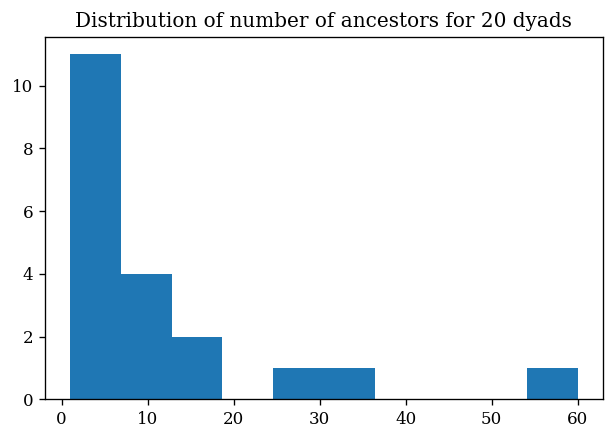

1     5
2     4
29    1
60    1
3     1
18    1
13    1
11    1
10    1
8     1
7     1
6     1
35    1
dtype: int64

In [57]:
x = [len(values) for values in dyad_activity_map.values()]
plt.hist(x)
plt.title(f"Distribution of number of ancestors for {len(dyad_activity_map)} dyads")
plt.show()
pd.Series(x).value_counts()

In [ ]:
class NiceNameCounter:
    def __init__(self, participant_id_set, recced_author_set):
        self.participant_id_set = participant_id_set
        self.recced_author_set = recced_author_set
        
        self.nice_name_map = {
            'Participant': {},
            'Recced_author': {},
            'Visitor': {},
            'Site': {},
        }
        self.nice_name_counter = {
            'Participant': 1,
            'Recced_author': 1,
            'Visitor': 1,
            'Site': 1,
        }
        
    def get_nice_name(self, user_id):
        if user_id in self.participant_id_set:
            user_type = 'Participant'
        elif user_id in self.recced_author_set:
            user_type = 'Recced_author'
        else:
            user_type = 'Visitor'
        
        if user_id not in self.nice_name_map[user_type]:
            self.nice_name_map[user_type][user_id] = self.nice_name_counter[user_type]
            self.nice_name_counter[user_type] += 1
        nice_name = f"{user_type[0]}{self.nice_name_map[user_type][user_id]}"
        return nice_name
    
    def get_nice_site_name(self, site_id):
        user_type = 'Site'
        if site_id not in self.nice_name_map[user_type]:
            self.nice_name_map[user_type][site_id] = self.nice_name_counter[user_type]
            self.nice_name_counter[user_type] += 1
        nice_name = f"{user_type[0]}{self.nice_name_map[user_type][site_id]}"
        return nice_name
    
nn = NiceNameCounter(participant_user_ids, recced_user_ids)

# identify sort order for dyads
dyad_list = []
for dyad_id, ancestors in dyad_activity_map.items():
    participant_user_id, recced_site_id = dyads_to_users_map[dyad_id]
    n_ancestors = len(ancestors)
    tup = (participant_user_id, n_ancestors, dyad_id)
    dyad_list.append(tup)
dyad_list.sort(reverse=True)
dyad_id_list = [dyad[2] for dyad in dyad_list]
print(dyad_list)

with open('dyad_activity.csv', 'w', newline='') as outfile:
    csvwriter = csv.writer(outfile)
    csvwriter.writerow([
        'who?',
        'datetime',
        'activity type',
        'user',
        'user role',
        'site',
        'site type',
        'text',
        'OID',
    ])
    
    for dyad_id in dyad_id_list:
        ancestors = dyad_activity_map[dyad_id]
        
        participant_user_id, recced_site_id = dyads_to_users_map[dyad_id]
        
        rec_info = rec_df[(rec_df.participant_id == participant_user_id)&(rec_df.site_id == recced_site_id)].iloc[0]
        
        csvwriter.writerow([
            f"Dyad {dyad_id}: {nn.get_nice_name(participant_user_id)} to {nn.get_nice_site_name(recced_site_id)}", 
            datetime.utcfromtimestamp(rec_info.sse_sent_timestamp / 1000).strftime("%Y-%m-%d %H:%M"),
            "Dyad",
            nn.get_nice_name(participant_user_id), 
            rec_info.first_name,
            nn.get_nice_site_name(recced_site_id),
            rec_info.site_name,
            rec_info.site_title,
            f"{len(ancestors)} journals/guestbooks"
        ])
        
        from_participant_str = f"By participant {nn.get_nice_name(participant_user_id)}"
        from_rec_author_str = f"By author of recced site {nn.get_nice_site_name(recced_site_id)}"
        def get_status(user_id):
            is_from_participant = user_id == participant_user_id
            is_from_rec_author = user_id in recced_site_id_to_user_id_map[recced_site_id]
            if is_from_participant:
                return from_participant_str
            elif is_from_rec_author:
                return from_rec_author_str
            else:
                return "By other user"

        
        ancestors.sort(key=lambda ancestor: ancestor['created_at'])
        for ancestor in ancestors:
            is_from_participant = ancestor['user_id'] == participant_user_id
            is_from_rec_author = ancestor['user_id'] in recced_site_id_to_user_id_map[recced_site_id]
            
            csvwriter.writerow([
                get_status(ancestor['user_id']),
                ancestor['datetime'],
                ancestor['ancestor_type'],
                nn.get_nice_name(ancestor['user_id']), 
                ancestor['user_type'],
                nn.get_nice_site_name(ancestor['site_id']), 
                ancestor['site_type'],
                ancestor['text'],
                ancestor['oid'],
            ])
            if 'comments' in ancestor:
                for comment in ancestor['comments']:
                    
                    row = [
                        get_status(comment['user_id']), 
                        comment['datetime'],
                        "reply" if comment['parent_type'] == 'comment' else "comment",
                        nn.get_nice_name(comment['user_id']),
                        comment['user_type'],
                        "",
                        "    Reply" if comment['parent_type'] == 'comment' else "Comment",
                        comment['comment_text'],
                        comment['comment_oid'],
                    ]
                    csvwriter.writerow(row)
            csvwriter.writerow([])
        csvwriter.writerow([f"End of dyad {dyad_id}"])
        csvwriter.writerow([])

In [118]:
activity_df = pd.DataFrame(activity_rows, columns=comment_column_names)
len(activity_df)

437

In [ ]:
activity_df.sample(n=3)

In [120]:
activity_df.comment_type.value_counts()

participant_comment    380
rec_comment             47
participant_reply        6
rec_reply                4
Name: comment_type, dtype: int64

In [121]:
# how many journals did we fail to retrieve text data for?
np.sum(activity_df.context_journal == 'NOT IN DB')

1

In [122]:
activity_df.note.value_counts()

    437
Name: note, dtype: int64

In [123]:
participant_comments = activity_df[activity_df.comment_type == 'participant_comment'].sort_values(by='created_at') 
participant_initiations = participant_comments.drop_duplicates(subset=['source_user_id', 'target_site_id'])
len(participant_comments), len(participant_initiations)

(380, 26)

In [124]:
registered_tokens = ()
i = 0
dyad_id_map = {}
dyad_ids = []
for row in activity_df.itertuples():
    key = (row.source_user_id, row.target_user_id)
    key2 = (row.target_user_id, row.source_user_id)
    if key not in dyad_id_map:
        dyad_id_map[key] = i
        dyad_id_map[key2] = i
        i += 1
    dyad_ids.append(dyad_id_map[key])
activity_df['dyad_id'] = dyad_ids

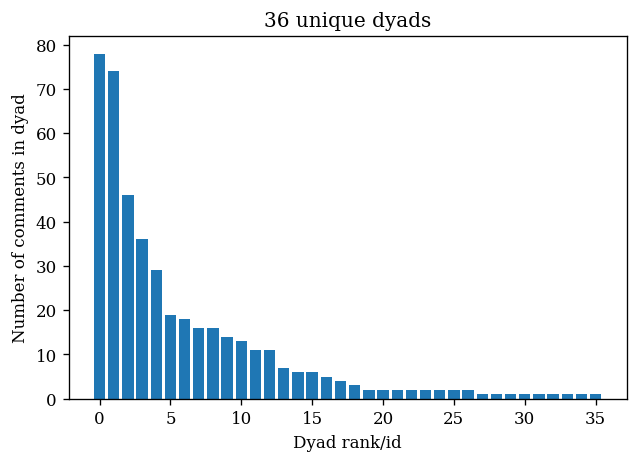

In [125]:
fig, ax = plt.subplots()
n_comments = activity_df.dyad_id.value_counts()
ax.bar(range(len(n_comments)), n_comments)
ax.set_title(f"{len(set(activity_df.dyad_id))} unique dyads")
ax.set_ylabel("Number of comments in dyad")
ax.set_xlabel("Dyad rank/id")
plt.show()

In [ ]:
# how many dyads is each participant in?
# TODO

In [144]:
activity_df.groupby('dyad_id')\
    .agg({'comment_oid': lambda co: co.nunique(), 'comment_type': lambda ct: ct.value_counts().to_dict()})\
    .rename(columns={'comment_oid': 'n_comments'})\
    .sort_values(by='n_comments', ascending=False)

,n_comments,comment_type
dyad_id,,
3,78,{'participant_comment': 78}
2,74,"{'participant_comment': 59, 'participant_reply..."
27,46,{'participant_comment': 46}
0,36,{'participant_comment': 36}
13,29,{'participant_comment': 29}
1,19,{'rec_comment': 19}
28,18,"{'rec_comment': 15, 'participant_comment': 3}"
10,16,{'participant_comment': 16}
6,16,{'participant_comment': 16}


In [ ]:
activity_df = activity_df.sort_values(by=['dyad_id', 'created_at'])
activity_df.head()

In [127]:
activity_df['comment_time']  = activity_df.created_at.map(lambda ca: datetime.utcfromtimestamp(ca / 1000).strftime("%Y-%m-%d %H:%M"))

In [128]:
activity_df.to_csv('comment_activity.csv', index=False)

In [147]:
participant_comments = activity_df[activity_df.comment_type.str.startswith('participant_')].sort_values(by='created_at') 
participant_initiations = participant_comments.drop_duplicates(subset=['source_user_id', 'target_site_id'])
participant_initiations.to_csv('participant_comment_initiations.csv', index=False)
len(participant_initiations)

26

In [111]:
#output_filepath = os.path.join(activity_dir, 'comment_activity.csv')


## Survey data

### Visits and Follows

From the site_profile diffs, look for:
 - Visits to the site
 - Follows of the site
 - Role changes (specifically to "Removed", but anything involving Organizer's is interesting too)

In [22]:
from cbcore.script.computeCollectionCounts import iterate_collection
# identify site_profiles for participants
site_profiles = []
input_filepath = os.path.join(cbcore.data.paths.raw_data_filepath, 'site_profile.bson.gz')
for doc in tqdm(iterate_collection(input_filepath), desc='Processing documents', total=83000000):
    user_id = int(doc['userId']) if 'userId' in doc else -1
    if user_id in participant_user_ids:
        site_profiles.append(doc)
len(site_profiles)

Processing documents: 83881536it [2:14:53, 10363.54it/s]                                


836

In [23]:
# save the processed site_profiles to pickle
output_dir = os.path.join(cbcore.data.paths.projects_data_dir, 'recsys-peer-match', 'participant')
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'site_profile.pkl'), 'wb') as outfile:
    pickle.dump(site_profiles, outfile)

In [ ]:
# load the site profiles
with open(os.path.join(participant_data_dir, 'site_profile.pkl'), 'rb') as infile:
    site_profiles = pickle.load(infile)
print(len(site_profiles))

# create a dataframe from the site profile entires
ds = []
for sp in site_profiles:
    user_id = int(sp['userId'])
    site_id = int(sp['siteId']) if 'siteId' in sp else -1
    # not capturing: n, nl
    d = {
        'user_id': user_id,
        'site_id': site_id,
        'is_creator': sp['isCreator'] if 'isCreator' in sp else None,
        'is_primary': sp['isPrimary'] if 'isPrimary' in sp else None,
        'role': sp['role'],
        'is_profile_deleted': sp['isProfileDeleted'] if 'isProfileDeleted' in sp else None,
        'is_site_deleted': sp['isSiteDeleted'] if 'isSiteDeleted' in sp else None,
        'is_stub': sp['isStub'] if 'isStub' in sp else None,
        'created_at': sp['createdAt'].timestamp() * 1000 if 'createdAt' in sp else 0,
        'updated_at': sp['updatedAt'].timestamp() * 1000 if 'updatedAt' in sp else 0,
        'n': dict(sp['n']) if 'n' in sp and sp['n'] is not None else {},
    }
    ds.append(d)

ssite_profile_df = pd.DataFrame(ds)
ssite_profile_df.sample(n=10, random_state=0)

In [ ]:
dict(site_profiles[0])

In [58]:
rsite_profile_df = ssite_profile_df.set_index(['user_id', 'site_id']).sort_index()
rsite_profile_df = rsite_profile_df.loc[rsite_profile_df.index.intersection(recced_usps)].reset_index()
len(rsite_profile_df)

189

In [ ]:
rsite_profile_df.head()

## First clicks analysis

In [60]:
# load the site metadata dataframe
# this is created in caringbridge_core from the new data
site_metadata_working_dir = "/home/lana/shared/caringbridge/data/derived/site_metadata"
s = datetime.now()
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_info_df = pd.read_feather(site_metadata_filepath)
assert np.sum(site_info_df.site_id.value_counts() > 1) == 0, "Site ids are not globally unique."
print(datetime.now() - s)
len(site_info_df)

0:00:03.344280


1195834

In [61]:
n_duplicate_names = np.sum(site_info_df.name.value_counts() > 1)
print(f"{n_duplicate_names} ({n_duplicate_names / len(site_info_df):.2%} duplicate site URL names.")

166 (0.01% duplicate site URL names.


In [62]:
# remove duplicate site names from the site_info_df
# keeping the most recent by created_at date
print(len(site_info_df))
site_info_df = site_info_df.sort_values(by='created_at').drop_duplicates(subset='name', keep='last', ignore_index=True)
print(len(site_info_df))

1195834
1195665


In [63]:
# add site_id to the cloudfront data
scf_df = pd.merge(scf_df, site_info_df[['site_id', 'name']], how='left', left_on='site_name', right_on='name', validate='many_to_one')
len(scf_df)

231

In [64]:
first_clicks = scf_df.sort_values(by='timestamp').drop_duplicates(subset=['user_id', 'site_id'], keep='first')
len(first_clicks)

196

In [65]:
first_clicks_map = {(row.user_id, row.site_id): row.timestamp for row in first_clicks.itertuples()}
first_visits_map = {(row.user_id, row.site_id): row.created_at / 1000 for row in rsite_profile_df.itertuples()}
len(first_clicks_map), len(first_visits_map)

(196, 189)

In [66]:
# clicks & logged-in visits are not the same...
set(first_clicks_map.keys()) == set(first_visits_map.keys())

False

In [67]:
all_first_click_or_visit_pairs = set(first_clicks_map.keys()) | set(first_visits_map.keys())
len(all_first_click_or_visit_pairs)

218

In [68]:
participant_rec_map = {}
for user_id, group in batch_df.groupby('participant_id'):
    participant_rec_map[user_id] = []
    for sse in group.itertuples():
        for site in sse.sse_site_list:
            participant_rec_map[user_id].append(site['site_id'])
len(participant_rec_map)

79

In [69]:
participant_rec_time_map = {}
for user_id, group in batch_df.groupby('participant_id'):
    participant_rec_time_map[user_id] = {}
    for sse in group.itertuples():
        for site in sse.sse_site_list:
            participant_rec_time_map[user_id][site['site_id']] = sse.sse_sent_timestamp
len(participant_rec_time_map)

79

In [70]:
n_total = 0
n_visit_only = 0
n_click_only = 0
n_both = 0
n_visit_unrelated_to_rec = 0
n_visit_pre_rec = 0
rec_to_visit_time_diffs = []
click_to_visit_time_diffs = []

for usp in all_first_click_or_visit_pairs:
    if usp in first_clicks_map:
        first_click_ts = first_clicks_map[usp]
    else:
        first_click_ts = None
    if usp in first_visits_map:
        first_visit_ts = first_visits_map[usp]
    else:
        first_visit_ts = None
    
    n_total += 1
    if first_visit_ts and first_click_ts:
        n_both += 1
        click_to_visit_time_diffs.append(first_visit_ts - first_click_ts)
    elif first_visit_ts and not first_click_ts:
        # didn't register click OR visited pre-study
        n_visit_only += 1
        
        user_id, site_id = usp
        # was this site actually recommended?
        was_recced = site_id in participant_rec_map[user_id]
        if not was_recced:
            n_visit_unrelated_to_rec += 1
            continue
        # did this visit occur before the associated recommendation?
        recced_time = participant_rec_time_map[user_id][site_id] / 1000
        rec_to_visit_time_diffs.append(first_visit_ts - recced_time)
        if first_visit_ts < recced_time:
            n_visit_pre_rec += 1
        print(datetime.utcfromtimestamp(recced_time).isoformat())
        
    elif not first_visit_ts and first_click_ts:
        # visit while not logged in
        n_click_only += 1
    elif not first_visit_ts and not first_click_ts:
        raise ValueError("what?")
    else:
        raise ValueError("big what.")
n_total, n_visit_only, n_click_only, n_both, n_visit_unrelated_to_rec, n_visit_pre_rec

2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-17T22:24:33.098000
2021-09-02T19:57:26
2021-09-24T16:39:56.622000
2021-09-02T19:57:26
2021-11-02T21:24:16.874000
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-24T16:39:55.448000
2021-11-17T18:02:58.614000
2021-09-02T19:57:26
2021-11-17T18:02:58.614000
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-11-02T21:23:22.643000
2021-09-02T19:57:26
2021-09-02T19:57:26
2021-09-17T22:24:18.791000
2021-09-02T19:57:26
2021-11-02T21:23:22.643000


(218, 22, 29, 167, 0, 0)

In [71]:
22 / len(scf_df)

0.09523809523809523

In [72]:
# time in hours between rec email sent time and the visit
# no obvious patterns... seems to approximately mirror the distribution of time_to_click
np.array(rec_to_visit_time_diffs) / 60 / 60

array([ 0.25611111,  0.31527778,  1.44333333, 63.44163944,  0.29611111,
       41.54427167,  0.33805556,  2.81614611,  1.44611111,  1.43527778,
        7.14070889,  2.857885  ,  1.44861111,  2.89149611,  0.27916667,
       14.60166667, 11.7684325 ,  0.31388889, 14.6275    , 26.14255806,
       14.61916667, 11.70398806])

In [73]:
click_to_visit_time_diffs = np.array(click_to_visit_time_diffs)
len(click_to_visit_time_diffs)

167

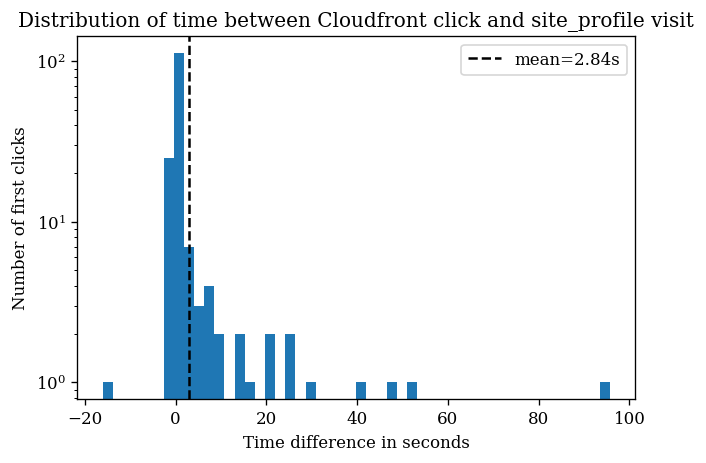

In [74]:
plt.hist(click_to_visit_time_diffs, log=True, bins=50)
plt.axvline(np.mean(click_to_visit_time_diffs), label=f"mean={np.mean(click_to_visit_time_diffs):.2f}s", color='black', linestyle='--')
plt.legend()
plt.title("Distribution of time between Cloudfront click and site_profile visit")
plt.xlabel("Time difference in seconds")
plt.ylabel("Number of first clicks")
plt.show()

In [75]:
first_clicks = scf_df.sort_values(by='timestamp').drop_duplicates(subset=['user_id', 'site_id'], keep='first')
first_click_map = {(row.user_id, row.site_id): row.timestamp for row in first_clicks.itertuples()}
for row in rsite_profile_df.itertuples():
    usp = (row.user_id, row.site_id)
    if usp not in first_click_map:
        first_click_map[usp] = int(row.created_at / 1000)
len(first_click_map)

218

In [76]:
first_click_timestamps = []
for row in rec_df.itertuples():
    usp = (row.user_id, row.site_id)
    if usp in first_click_map:
        first_click_timestamp = first_click_map[usp]
    else:
        first_click_timestamp = -1
    first_click_timestamps.append(first_click_timestamp)
# convert to milliseconds
rec_df['first_click_timestamp'] = np.array(first_click_timestamps) * 1000
rec_df['was_clicked'] = rec_df.first_click_timestamp >= 0
rec_df.was_clicked.value_counts()

False    3972
True      218
Name: was_clicked, dtype: int64

In [77]:
f"{np.sum(rec_df.was_clicked) / len(rec_df):.2%} of site recommendations were clicked"

'5.20% of site recommendations were clicked'

In [ ]:
sdf = rec_df[rec_df.was_clicked]
#assert np.all(sdf.first_click_timestamp > sdf.sse_sent_timestamp)
plt.hist((sdf.first_click_timestamp - sdf.sse_sent_timestamp) / 1000 / 60 / 60, bins=np.arange(-5, 100))
plt.xlabel("Time to click (hours)")
plt.ylabel("Distribution of time-to-click")
plt.show()
sdf[(sdf.first_click_timestamp - sdf.sse_sent_timestamp) < 0]

In [79]:
first_click_df = rec_df[rec_df.was_clicked]

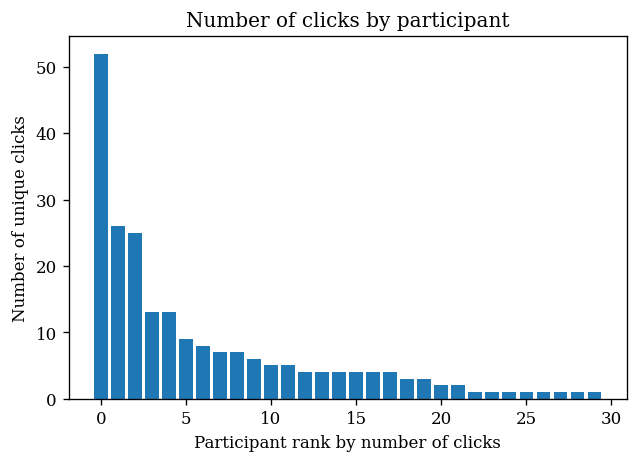

In [80]:
ys = first_click_df.user_id.value_counts()
xs = range(len(ys))
plt.bar(xs, ys)
plt.title("Number of clicks by participant")
plt.xlabel("Participant rank by number of clicks")
plt.ylabel("Number of unique clicks")
plt.show()

In [81]:
# compute number of clicks at the batch level
batch_clicked_map = {}
for sse, group in rec_df.groupby(['participant_id', 'batch_id']):
    n_clicked = np.sum(group.was_clicked)
    batch_clicked_map[sse] = n_clicked
n_batch_clicks_list = []
for row in batch_df.itertuples():
    n_batch_clicks = batch_clicked_map[(row.participant_id, row.batch_id)]
    n_batch_clicks_list.append(n_batch_clicks)
batch_df['n_batch_clicks'] = n_batch_clicks_list
batch_df.n_batch_clicks.value_counts()

0    756
1     32
5     19
2     12
4     10
3      9
Name: n_batch_clicks, dtype: int64

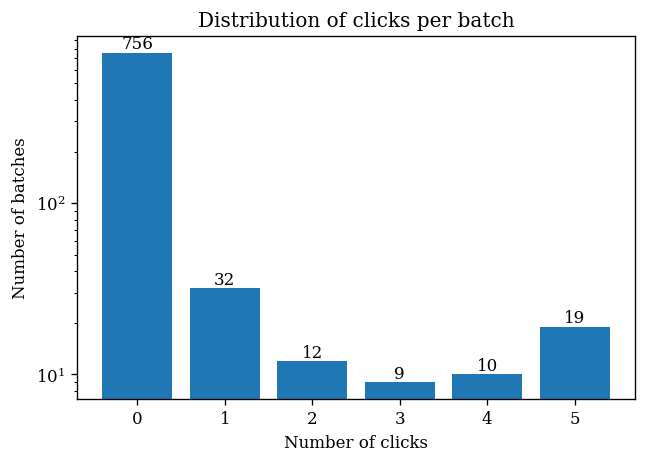

In [82]:
counts, _ = np.histogram(batch_df.n_batch_clicks, bins = np.arange(0, 7))
#plt.hist(batch_df.n_batch_clicks, , log=True)
plt.bar(range(len(counts)), counts)
plt.yscale('log')
for i, count in enumerate(counts):
    plt.text(i, count, f"{count}", ha='center', va='bottom')
plt.xlabel("Number of clicks")
plt.ylabel("Number of batches")
plt.title("Distribution of clicks per batch")
plt.show()

In [ ]:
# six participants clicked every link in an email
batch_df[batch_df.n_batch_clicks == 5].participant_id.value_counts()

#### v1 annotations

Every annotation in a batch that was clicked at least once (but not 5 times).

In [84]:
eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[(batch_df.n_batch_clicks > 0)&(batch_df.n_batch_clicks < 5)].itertuples()]
len(eligible_batches)

63

In [185]:
header = ['site_id','journal_oid','site_title','cleaned_journal_title','cleaned_journal_body',
          'NOT what/how patient is doing?','good news?','bad news?','EOA/gratitude?','author visible?','expressive writing?']
clicked_batch_sse_annotation_filepath = os.path.join(participant_data_dir, 'clicked_batch_sse_annotation_v1.tsv')

duplicate_avoided = 0
lines_written = 0
written_journal_oids = set()
with open(clicked_batch_sse_annotation_filepath, 'w') as outfile:
    outfile.write('\t'.join(header) + '\n')
    for row in rec_df.sample(frac=1).itertuples():
        if (row.participant_id, row.batch_id) in eligible_batches:
            if row.journal_oid in written_journal_oids:
                duplicate_avoided += 1
                continue
            written_journal_oids.add(row.journal_oid)
            cleaned_journal_title = row.cleaned_journal_title.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            cleaned_journal_body = row.cleaned_journal_body.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            line = f"{row.site_id}\t{row.journal_oid}\t{row.site_title}\t\"{cleaned_journal_title}\"\t\"{cleaned_journal_body}\"\t\t\t\t\t\t\n"
            assert '\n' not in line[:-1]
            outfile.write(line)
            lines_written += 1
lines_written, duplicate_avoided

(242, 73)

In [186]:
with open(clicked_batch_sse_annotation_filepath, 'r') as infile:
    for line in infile:
        tokens = line.split("\t")
        assert len(tokens) == 11, line

In [187]:
len(pd.read_csv(clicked_batch_sse_annotation_filepath, sep='\t', header=0))

242

#### v2 annotations

Every batch from a participant that clicked at least once.

In [87]:
v1_clicked_batch_sse_annotation_filepath = os.path.join(participant_data_dir, 'clicked_batch_sse_annotation_v1.tsv')
v1_journal_oids = set(pd.read_csv(v1_clicked_batch_sse_annotation_filepath, sep='\t', header=0).journal_oid)
len(v1_journal_oids)

242

In [89]:
# identify every participant who clicked at least once
eligible_participants = set([row.participant_id for row in batch_df[batch_df.n_batch_clicks > 0].itertuples()])
# identify all batches already present in the v1 annotations
v1_eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[(batch_df.n_batch_clicks > 0)&(batch_df.n_batch_clicks < 5)].itertuples()]
# identify all batches NOT in v1 but that are
eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[batch_df.participant_id.isin(eligible_participants)].itertuples()
                   if (row.participant_id, row.batch_id) not in v1_eligible_batches]
len(eligible_batches)

255

In [90]:
header = ['site_id','journal_oid','site_title','cleaned_journal_title','cleaned_journal_body',
          'NOT what/how patient is doing?','good news?','bad news?','EOA/gratitude?','author visible?','expressive writing?']
clicked_batch_sse_annotation_filepath = os.path.join(participant_data_dir, 'clicked_batch_sse_annotation_v2.tsv')

duplicate_avoided = 0
lines_written = 0
written_journal_oids = set()
with open(clicked_batch_sse_annotation_filepath, 'w') as outfile:
    outfile.write('\t'.join(header) + '\n')
    for row in rec_df.sample(frac=1).itertuples():
        if (row.participant_id, row.batch_id) in eligible_batches:
            if row.journal_oid in written_journal_oids or row.journal_oid in v1_journal_oids:
                duplicate_avoided += 1
                continue
            written_journal_oids.add(row.journal_oid)
            cleaned_journal_title = row.cleaned_journal_title.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            cleaned_journal_body = row.cleaned_journal_body.replace('\t', '    ').replace('\n', ' NEWLINE ').replace('"', '\\"')
            line = f"{row.site_id}\t{row.journal_oid}\t{row.site_title}\t\"{cleaned_journal_title}\"\t\"{cleaned_journal_body}\"\t\t\t\t\t\t\n"
            assert '\n' not in line[:-1]
            outfile.write(line)
            lines_written += 1
lines_written, duplicate_avoided

(376, 899)

In [91]:
len(pd.read_csv(clicked_batch_sse_annotation_filepath, sep='\t', header=0))

376

#### v3 annotations

Random sample of some kind. Sensible options:
 - Random sample of batches (able to answer "what % of batches contained good news?")
 - Random sample of recommended journals (able to answer: "what % of recommendations contained good news?")
 - Random sample of journals, weighted by occurrence (able to answer: "what % of the recommendations viewed by participants contained good news?")

In [94]:
# identify every participant who clicked at least once
eligible_participants = set([row.participant_id for row in batch_df[batch_df.n_batch_clicks > 0].itertuples()])
# identify all batches captured in v1 and v2
v1_v2_eligible_batches = [(row.participant_id, row.batch_id) for row in batch_df[batch_df.participant_id.isin(eligible_participants)].itertuples()]
len(v1_v2_eligible_batches)

318

In [98]:
# TODO figure out how we want to random sample
# keep track of which updates are present in v1_v2_eligible_batches and make sure we don't multiply annotate them...
# this will be somewhat complicated code I think, probably need to change how we sample the rec_df
len(rec_df)

4190

#### Utility bash for copying and transferring files



In [92]:
!cp {clicked_batch_sse_annotation_filepath} .
!pwd
!ls ./*.tsv

/panfs/roc/groups/1/lana/levon003/repos/recsys-peer-match/notebook/survey
./clicked_batch_sse_annotation_v2.tsv


In [ ]:
# load the site profile diff
s = datetime.now()
site_profile_diff_filepath = os.path.join(cbcore.data.paths.projects_data_dir, 'caringbridge_core', 'site_profile_diff', 'site_profile_diff.tsv')
site_profile_diff_df = pd.read_csv(site_profile_diff_filepath, sep='\t', header=0)
print(f"Read {len(site_profile_diff_df)} rows in {datetime.now() - s}.")
site_profile_diff_df.head()

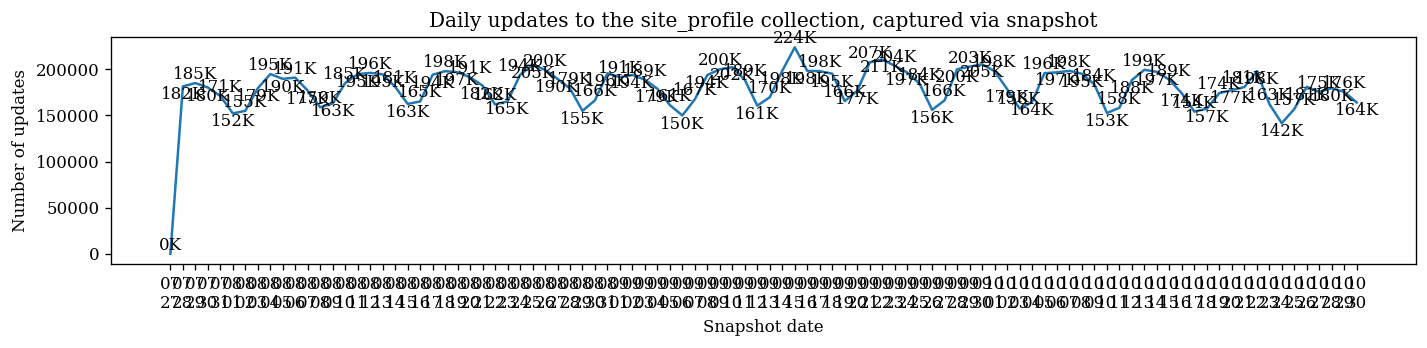

182890.0

In [41]:
daily_counts = site_profile_diff_df.snapshot_date.value_counts().sort_index()

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

xs = np.arange(len(daily_counts))
ax.plot(xs, daily_counts)
nl = '\n'
for x, count in zip(xs, daily_counts):
    ax.text(x, count, f"{count / 1000:,.0f}K", ha='center', va='bottom' if x % 2 == 0 else 'top')  # {nl if x % 2 == 0 else ''}

ax.set_xticks(xs)
ax.set_xticklabels([f"{str(i)[4:6]}\n{str(i)[6:]}" for i in daily_counts.index])

ax.set_title("Daily updates to the site_profile collection, captured via snapshot")
ax.set_xlabel("Snapshot date")
ax.set_ylabel("Number of updates")

plt.tight_layout()
plt.show()

np.median(daily_counts)

In [42]:
site_profile_diff_df.key.value_counts()

updatedAt    16834928
role           225536
n              213113
Name: key, dtype: int64

In [43]:
rsite_profile_diff_df = site_profile_diff_df.set_index(['user_id', 'site_id']).sort_index()
rsite_profile_diff_df = rsite_profile_diff_df.loc[rsite_profile_diff_df.index.intersection(recced_usps)].reset_index()
len(rsite_profile_diff_df)

265

In [ ]:
rsite_profile_diff_df.head()

In [45]:
# how many unique user->site updates did we observe?
rsite_profile_diff_df.groupby(['user_id', 'site_id']).ngroups

65

In [46]:
sp_df = rsite_profile_diff_df.merge(rsite_profile_df, how='outer', on=['user_id', 'site_id'])
len(sp_df)

357

In [ ]:
sp_df.head()

In [48]:
sp_df.key.value_counts()

updatedAt    209
role          49
n              7
Name: key, dtype: int64

In [49]:
# visit actions
#sdf = sp_df[sp_df.key == 'updatedAt']
ds = []
for usp, group in sp_df.groupby(['user_id', 'site_id']):
    n_potential_missed_visits = 0
    prev_visit_timestamp = int(group.iloc[0].created_at)
    visit_timestamps = [prev_visit_timestamp,]
    for row in group[group.key == 'updatedAt'].sort_values(by='new_value').itertuples():
        new_value = int(row.new_value) * 1000
        old_value = int(row.old_value) * 1000
        assert new_value > old_value
        assert new_value > prev_visit_timestamp, f"{new_value} {prev_visit_timestamp}"
        if old_value != prev_visit_timestamp:
            assert old_value > prev_visit_timestamp
            n_potential_missed_visits += 1
            visit_timestamps.append(old_value)
        visit_timestamps.append(new_value)
        prev_visit_timestamp = new_value
    n_visits = len(visit_timestamps)
    ds.append({
        'user_id': usp[0],
        'site_id': usp[1],
        'n_visits': n_visits,
        'n_potential_missed_visits': n_potential_missed_visits,
        'visit_timestamps': visit_timestamps,
    })
visit_df = pd.DataFrame(ds)
len(visit_df)

157

In [ ]:
visit_df.sort_values(by='n_visits', ascending=False).head(10)

In [ ]:
visit_df.groupby('user_id').n_visits.sum().sort_values(ascending=False)

In [52]:
visit_df.groupby('user_id').n_visits.sum().sum()

410

In [54]:
# how many "return visits" are there?
def count_return_visits(visit_timestamps):
    if len(visit_timestamps) <= 1:
        return 0
    return_visit_threshold = 1000 * 60 * 60 * 6  # 6 hours
    
    n_return_visits = 0
    first_timestamp = visit_timestamps[0]
    for timestamp in visit_timestamps[1:]:
        if timestamp > first_timestamp + return_visit_threshold:
            n_return_visits += 1
    return n_return_visits
visit_df['n_return_visits'] = visit_df.visit_timestamps.map(count_return_visits)
visit_df.n_return_visits.value_counts()

0     113
1      23
3       4
4       3
16      2
14      2
7       2
5       2
2       2
24      1
23      1
20      1
8       1
Name: n_return_visits, dtype: int64

In [57]:
visit_df.n_return_visits.sum(), np.sum(visit_df.n_return_visits > 0)

(210, 44)

In [60]:
len(visit_df.groupby('user_id').n_return_visits.count())

28

In [ ]:
# TODO create a visit_df with all of the participants visits, and then compute pre/post comparison?

In [ ]:
# follow actions
sp_df[sp_df.key == 'n']

In [ ]:
# currently, this is a reasonable estimate of number of follow actions
sp_df[sp_df.n.map(lambda n: len(n) > 0)].groupby(['user_id', 'site_id']).updated_at.nunique()

In [137]:
sp_df.n.map(lambda n: len(n)).value_counts()

0    180
1    117
4     30
2     30
Name: n, dtype: int64

In [139]:
pd.crosstab(sp_df.key, sp_df.n.map(lambda n: len(n)), dropna=False)

n,0,1,2,4
key,,,,
n,0,6,1,0
role,47,1,1,0
updatedAt,41,110,28,30


## Interactions and journals

In [25]:
# load the journal dataframe with the index
s = datetime.now()
journal_metadata_dir = "/home/lana/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.feather")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:16.162211


20666627

In [ ]:
# read interactions dataframe
s = datetime.now()
model_data_dir = '/home/lana/shared/caringbridge/data/projects/recsys-peer-match/model_data'
ints_df = pd.read_feather(os.path.join(model_data_dir, 'ints_df.feather'))
print(f"Read {len(ints_df)} rows ({len(set(ints_df.user_id))} unique users) in {datetime.now() - s}.")
ints_df.head()

In [27]:
participant_user_ids = set(participant_df[participant_df.n_total_recs > 0].user_id)
len(participant_user_ids)

79

In [ ]:
participant_ints_df = ints_df[ints_df.user_id.isin(participant_user_ids)]
participant_ints_df = participant_ints_df.set_index(['user_id', 'site_id']).sort_index()
print(len(participant_ints_df))
participant_ints_df.head()

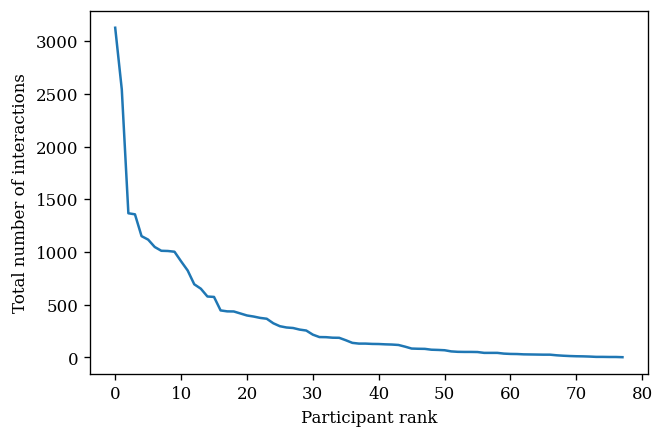

In [49]:
total_int_count = participant_ints_df.groupby('user_id').created_at.count().rename('total_int_count').sort_values(ascending=False)
plt.plot(range(len(total_int_count)), total_int_count)
plt.ylabel("Total number of interactions")
plt.xlabel("Participant rank")
plt.show()

In [32]:
rec_ints_df = participant_ints_df.loc[participant_ints_df.index.intersection(recced_usps)].reset_index()
len(rec_ints_df)

455

In [ ]:
rec_ints_df.groupby('user_id').site_id.count().sort_values(ascending=False)

In [ ]:
pd.crosstab(rec_ints_df.user_id, rec_ints_df.interaction_type)

In [ ]:
participant_df.head()

In [63]:
days30 = 1000 * 60 * 60 * 24 * 30
first_sse_timestamp_map = participant_df.set_index('user_id').first_sse_timestamp.to_dict()

ds = []
for user_id, group in participant_ints_df.groupby('user_id'):
    if user_id not in first_sse_timestamp_map:
        print("PANIC")
        continue
    first_sse_timestamp = first_sse_timestamp_map[user_id]
    if first_sse_timestamp == -1:
        continue
    n_total = len(group)
    n_post = np.sum(group.created_at >= first_sse_timestamp)
    n_pre = n_total - n_post
    
    
    n_post_30 = np.sum((group.created_at >= first_sse_timestamp)&(group.created_at <= first_sse_timestamp + days30))
    n_pre_30 = np.sum((group.created_at <= first_sse_timestamp)&(group.created_at >= first_sse_timestamp - days30))
    d = {
        'user_id': user_id,
        'n_pre_30': n_pre_30, 
        'n_post_30': n_post_30,
    }
    ds.append(d)
    
int_count_df = pd.DataFrame(ds)
len(int_count_df)

78

28.21% greater, 17.95% equal, 53.85% less interactions, when comparing 30 days post-study-start and 30 days pre-study-start


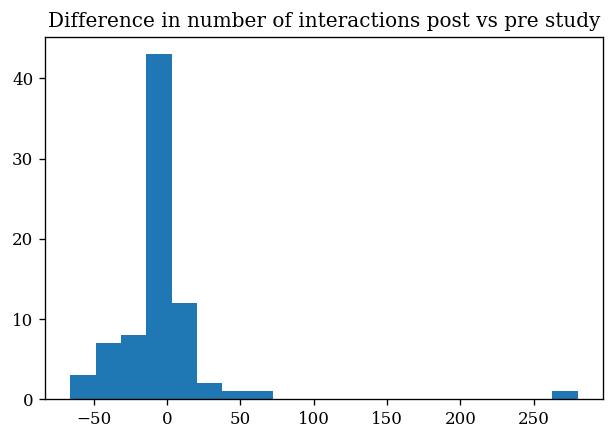

In [71]:
xs = int_count_df.n_post_30 - int_count_df.n_pre_30
print(f"{np.sum(xs > 0) / len(xs):.2%} greater, {np.sum(xs == 0) / len(xs):.2%} equal, {np.sum(xs < 0) / len(xs):.2%} less interactions, when comparing 30 days post-study-start and 30 days pre-study-start")
plt.hist(xs, bins=20)
plt.title("Difference in number of interactions post vs pre study")
plt.show()